In [1]:
import sys
sys.path.append('/n/home09/kboone/software/Cls_and_WST/')

import os
import torch
import pywph as pw
import numpy as np
from patchify import *
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'patchify'

# First Steps

To start I have to actually perform the proper projection of Euclid maps onto the patches and get a list of patches.

In [2]:
def ell(j, pix=3.44):
    # pix is the size in arcminutes
    return (3*np.pi/(2**(j+2))) / pix * 60 * 180 / np.pi

In [3]:
Om = 0.3175
d_Om = 0.01

s8 = 0.834
d_s8 = 0.015

In [4]:
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'

In [5]:
kyle_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/'
cmb_mask_dir = kyle_dir + 'cmb_conv/masks/'
wl_mask_dir = kyle_dir + 'cmb_x_wl/wl_masks/'

In [6]:
cmb_mask_files = os.listdir(cmb_mask_dir)
cmb_surveys = [cmb_mask_file.rstrip("npy") for cmb_mask_file in cmb_mask_files]
cmb_surveys = [cmb_survey.rstrip(".") for cmb_survey in cmb_surveys]
cmb_surveys = cmb_surveys[0:4]

cmb_mask_maps = []
for cmb_survey in cmb_surveys:
    cmb_mask_maps.append(np.load(cmb_mask_dir + cmb_survey + '.npy'))

In [7]:
wl_mask_files = os.listdir(wl_mask_dir)
wl_surveys = [wl_mask_file.rstrip("npy") for wl_mask_file in wl_mask_files]
wl_surveys = [wl_survey.rstrip(".") for wl_survey in wl_surveys]

wl_mask_maps = []
for wl_survey in wl_surveys:
    wl_mask_maps.append(np.load(wl_mask_dir + wl_survey + '.npy'))

# Generate WL Weights

In [8]:
patch_inds = np.load('../Data/Patches/patches_nside_1024.npy')
coords = np.load('../Data/Patches/coords_nside_1024.npy')
unmask = patch_inds > -0.5

In [9]:
# ind = 1
# wl_survey_mask = wl_mask_maps[ind] + 1

# patches = np.zeros_like(patch_inds)
# patches[unmask] = np.take(wl_survey_mask, patch_inds[unmask])

In [10]:
# counts = []
# for i in np.arange(len(patches)):
#     counts.append(len(np.where(patches[i] > 1.5)[0])) # /len(np.where(patches[i] > 0.5)[0])) # this is for weights
# counts = np.array(counts)
# # counts[np.where(counts<0.2)[0]] = 0

# np.save('../Data/Patches/counts_' + wl_surveys[ind] + '.npy', counts)

## Look at Patches

In [11]:
all_files = np.array(os.listdir(conv_dir))
fid_inds = [i for i, s in enumerate(all_files) if s.startswith('f')]
fid_dirs = all_files[fid_inds]

fid_dir = conv_dir + fid_dirs[0] + '/'

In [12]:
data = np.load(fid_dir + 'kappa_euclid_1024.npy')

In [13]:
high_z = data[5]

In [14]:
# ind = 0

# high_z[np.where(wl_mask_maps[ind]<0.5)] = 0

# weights = np.load('../Data/Patches/weights_' + wl_surveys[ind] + '.npy')
# patch_inds = np.load('../Data/Patches/patches_nside_1024.npy')[np.where(weights>0)]
# coords = np.load('../Data/Patches/coords_nside_1024.npy')[np.where(weights>0)]
# weights = weights[np.where(weights>0)]
# unmask = patch_inds > -0.5

In [15]:
# patches = np.zeros_like(patch_inds).astype(float)
# patches[unmask] = np.take(high_z, patch_inds[unmask])

In [16]:
# len(patches)

In [17]:
# np.min(weights)

In [18]:
# plot_patches(patches, coords, nrows=4, ncols=4, start_idx=0)

# WPH

To compute the cross coefficients, I want the area coverage to be the same, so I will be looking at intersections of maps. This is probably easiest to just do live time, don't have to write out way more files.

In [19]:
cmb_ind = 1
wl_ind = 1

total_mask = cmb_mask_maps[cmb_ind] + wl_mask_maps[wl_ind] + 1

In [20]:
print(cmb_surveys[cmb_ind])
print(wl_surveys[wl_ind])

Planck
dr3


In [21]:
patches = np.zeros_like(patch_inds)
patches[unmask] = np.take(total_mask, patch_inds[unmask])

In [22]:
weights = []
for i in np.arange(len(patches)):
    weights.append(len(np.where(patches[i] > 2.5)[0])  /len(np.where(patches[i] > 0.5)[0]))
weights = np.array(weights)
weights[np.where(weights<0.2)[0]] = 0

In [23]:
high_z[np.where(total_mask<2.5)] = 0

patch_inds_crop = patch_inds[np.where(weights>0)]
coords_crop = coords[np.where(weights>0)]
weights_crop = weights[np.where(weights>0)]
unmask_crop = patch_inds_crop > -0.5

In [24]:
patches = np.zeros_like(patch_inds_crop).astype(float)
patches[unmask_crop] = np.take(high_z, patch_inds_crop[unmask_crop])

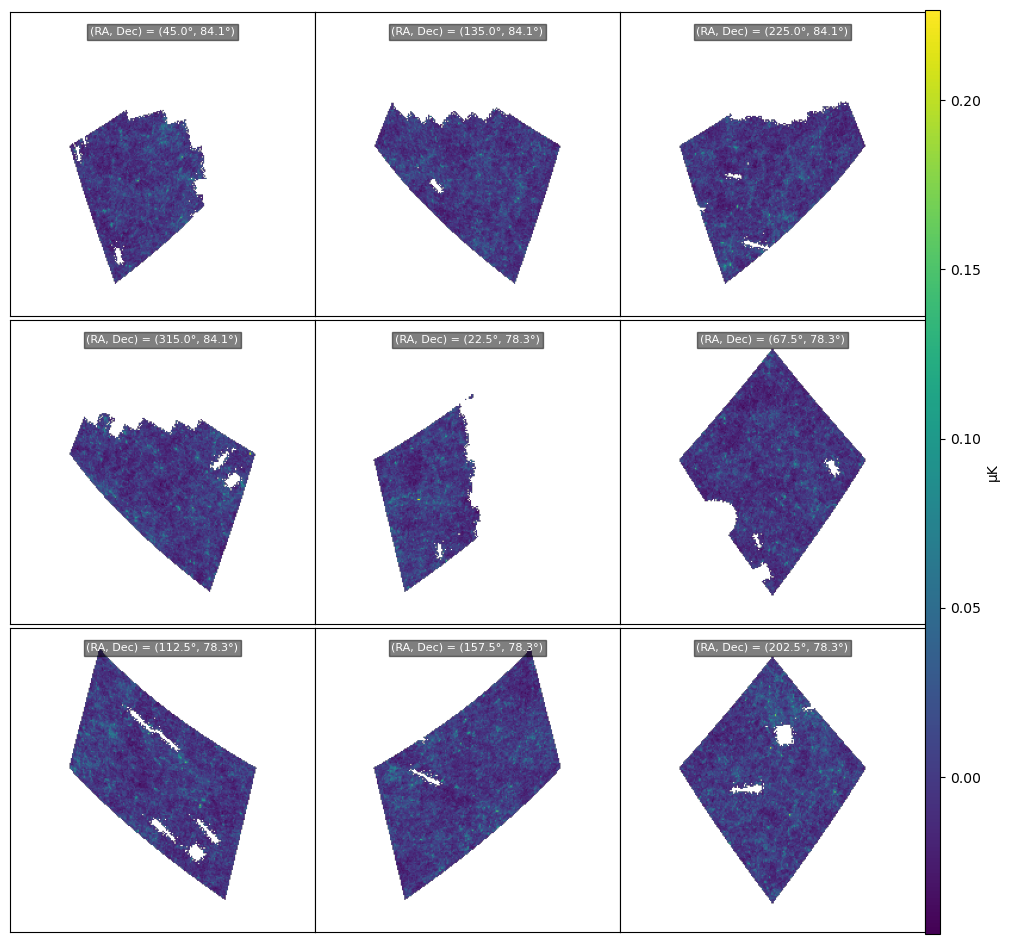

In [25]:
plot_patches(patches, coords, nrows=3, ncols=3, start_idx=0)

In [26]:
len(patches)

163

In [27]:
patches = patch_inds

In [2]:
# M, N = patches[0].shape
M, N = 256, 256
J = 7
L = 4
dn = 0
j_min = 0

# wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)

In [3]:
# wph = wph_op([patches[0], patches[1]], ret_wph_obj=True, cross=True)

In [4]:
def get_c01_indices(J: int, L: int):
    rows = []
    for j1 in range(J - 1):            # coarser scale
        for j2 in range(j1 + 1, J):    # finer scale
            for ell2 in range(L):      # every orientation on j₂
                rows.append([j1, 0, 0,   j2, ell2, 1,   0, 0, 0])

    arr = np.asarray(rows, dtype=int)
    return arr

In [5]:
def get_s00_indices(J: int):
    rows = []
    for j in range(J):
        rows.append([j, 0, 0, j, 0, 0, 0, 0, 0])
    return np.asarray(rows, dtype=int)


def get_s01_indices(J: int):
    rows = []
    for j in range(J):
        rows.append([j, 0, 0, j, 0, 1, 0, 0, 0])
    return np.asarray(rows, dtype=int)


def get_s11_indices(J: int):
    rows = []
    for j in range(J):
        rows.append([j, 0, 1, j, 0, 1, 0, 0, 0])
    return np.asarray(rows, dtype=int)

In [6]:
# wph_op = pw.WPHOp(M, N, J, L=L,j_min=j_min, dn=dn, device='cpu')
# # wph = wph_op([patch1, patch2], cross=True, ret_wph_obj=True)
# wph = wph_op([patches[0], patches[0]], cross=True, ret_wph_obj=True)
# wph.to_isopar()
# s00, s00_indices = wph.get_coeffs("S00")
# s11, s11_indices = wph.get_coeffs("S11")
# s01, s01_indices = wph.get_coeffs("S01")
# c01, c01_indices = wph.get_coeffs("C01")

s00_indices = get_s00_indices(J)
s01_indices = get_s01_indices(J)
s11_indices = get_s11_indices(J)
c01_indices = get_c01_indices(J,L)

In [7]:
c01_indices

array([[0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 2, 1, 0, 0, 0],
       [0, 0, 0, 1, 3, 1, 0, 0, 0],
       [0, 0, 0, 2, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 1, 1, 0, 0, 0],
       [0, 0, 0, 2, 2, 1, 0, 0, 0],
       [0, 0, 0, 2, 3, 1, 0, 0, 0],
       [0, 0, 0, 3, 0, 1, 0, 0, 0],
       [0, 0, 0, 3, 1, 1, 0, 0, 0],
       [0, 0, 0, 3, 2, 1, 0, 0, 0],
       [0, 0, 0, 3, 3, 1, 0, 0, 0],
       [0, 0, 0, 4, 0, 1, 0, 0, 0],
       [0, 0, 0, 4, 1, 1, 0, 0, 0],
       [0, 0, 0, 4, 2, 1, 0, 0, 0],
       [0, 0, 0, 4, 3, 1, 0, 0, 0],
       [0, 0, 0, 5, 0, 1, 0, 0, 0],
       [0, 0, 0, 5, 1, 1, 0, 0, 0],
       [0, 0, 0, 5, 2, 1, 0, 0, 0],
       [0, 0, 0, 5, 3, 1, 0, 0, 0],
       [0, 0, 0, 6, 0, 1, 0, 0, 0],
       [0, 0, 0, 6, 1, 1, 0, 0, 0],
       [0, 0, 0, 6, 2, 1, 0, 0, 0],
       [0, 0, 0, 6, 3, 1, 0, 0, 0],
       [1, 0, 0, 2, 0, 1, 0, 0, 0],
       [1, 0, 0, 2, 1, 1, 0, 0, 0],
       [1, 0, 0, 2, 2, 1, 0, 0, 0],
       [1, 0, 0, 2, 3, 1, 0,

In [76]:
all_wph_inds = np.concatenate([s00_indices, s11_indices, s01_indices, c01_indices, 
                               s00_indices, s11_indices, s01_indices, c01_indices, 
                               s01_indices, c01_indices, 
                               s01_indices, c01_indices])[:,:6]
scales = all_wph_inds[:,3]
scales = J*all_wph_inds[:,3] + all_wph_inds[:,0] # j2 with j1 tiebreaker
# scales = 2**all_wph_inds[:,0] + 2**all_wph_inds[:,3] # Sum of scales
summary_stat = np.concatenate([0*np.ones(len(s00_indices)), 1*np.ones(len(s11_indices)), 2*np.ones(len(s01_indices)), 3*np.ones(len(c01_indices))+c01_indices[:,4], (3+L)*np.ones(len(s00_indices)), (4+L)*np.ones(len(s11_indices)), (5+L)*np.ones(len(s01_indices)), (6+L)*np.ones(len(c01_indices))+c01_indices[:,4], (6+2*L)*np.ones(len(s01_indices)), (7+2*L)*np.ones(len(c01_indices))+c01_indices[:,4], (7+3*L)*np.ones(len(s01_indices)), (8+3*L)*np.ones(len(c01_indices))+c01_indices[:,4]])
track_inds = np.arange(len(all_wph_inds))
stat_sort = np.argsort(summary_stat)

all_wph_inds = all_wph_inds[stat_sort]
scales = scales[stat_sort]
summary_stat = summary_stat[stat_sort]
track_inds = track_inds[stat_sort]

groups = [np.where(summary_stat==v)[0] for v in np.unique(summary_stat)]

for group in groups:
    scale_sort = np.argsort(scales[group])[::-1]
    all_wph_inds[group] = all_wph_inds[group][scale_sort]
    scales[group] = scales[group][scale_sort]
    summary_stat[group] = summary_stat[group][scale_sort]
    track_inds[group] = track_inds[group][scale_sort]

In [77]:
scales[groups[0]]

array([99, 88, 77, 66, 55, 44, 33, 22, 11,  0])

In [78]:
_, counts = np.unique(summary_stat, return_counts=True)
x_pivots = (np.cumsum(counts)-0.5)[:-1]

In [81]:
# np.save('../Data/MCMC_Sorting/WPH_J'+str(J)+'_L'+str(L)+'_Inds.npy', track_inds)

In [82]:
# np.save('../Data/MCMC_Sorting/WPH_J'+str(J)+'_L'+str(L)+'_Pivots.npy', x_pivots)

In [65]:
# x_pivots

In [66]:
# y_pivots = np.sort(np.random.rand(len(x_pivots)))

In [67]:
# (np.append(np.atleast_2d(x_pivots), np.atleast_2d(y_pivots), axis=0).T).tolist()

In [85]:
len(np.load('/n/home09/kboone/software/Data/MCMC_Sorting/WPH_J10_L4_Inds.npy'))

800